# 6章 言語モデルのファインチューニング


## 事前準備

In [1]:
!curl -L -o genaibook.zip https://github.com/oreilly-japan/hands-on-generative-ai-ja/releases/download/genaibook/genaibook.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  4678  100  4678    0     0  10068      0 --:--:-- --:--:-- --:--:-- 10068


In [2]:
!unzip genaibook.zip

Archive:  genaibook.zip
Made with MacWinZipper (http://tidajapan.com/macwinzipper)
  inflating: genaibook/__init__.py   
  inflating: genaibook/core.py       


In [3]:
!pip install evaluate jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 66.0 MB/s eta 0:00:00


In [4]:
!pip install datasets==4.2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.3/506.3 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 55.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.2.1 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
pylibcudf-cu12 25.2.1 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.


In [6]:
!pip install --no-deps trl==0.23.1 bitsandbytes==0.48.1

  Using cached bitsandbytes-0.48.1-py3-none-manylinux_2_24_x86_64.whl.metadata (10 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.6/564.6 kB 17.8 MB/s eta 0:00:00
Using cached bitsandbytes-0.48.1-py3-none-manylinux_2_24_x86_64.whl (60.1 MB)


In [7]:
from huggingface_hub import login
login()

## テキストの分類


In [8]:
import datasets
import numpy as np
import torch
import transformers

np.set_printoptions(edgeitems=10, linewidth=70)
torch.set_printoptions(edgeitems=10, linewidth=70)


transformers.logging.set_verbosity_warning()
datasets.logging.set_verbosity_error()

### データセットの特定


In [9]:
from datasets import load_dataset

raw_datasets = load_dataset("ag_news")
raw_datasets

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [10]:
raw_train_dataset = raw_datasets["train"]
raw_train_dataset[0]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 'label': 2}

In [11]:
print(raw_train_dataset.features)

{'text': Value('string'), 'label': ClassLabel(names=['World', 'Sports', 'Business', 'Sci/Tech'])}


### データセットの前処理

In [12]:
from transformers import AutoTokenizer

checkpoint = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(batch):
    return tokenizer(
        batch["text"], truncation=True, padding=True, return_tensors="pt"
    )


tokenize_function(raw_train_dataset[:2])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

{'input_ids': tensor([[  101,  2813,  2358,  1012,  6468, 15020,  2067,  2046,
          1996,  2304,  1006, 26665,  1007, 26665,  1011,  2460,
          1011, 19041,  1010,  2813,  2395,  1005,  1055,  1040,
         11101,  2989,  1032,  2316,  1997, 11087,  1011, 22330,
          8713,  2015,  1010,  2024,  3773,  2665,  2153,  1012,
           102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101, 18431,  2571,  3504,  2646,  3293, 13395,  1006,
         26665,  1007, 26665,  1011,  2797,  5211,  3813, 18431,
          2571,  2177,  1010,  1032,  2029,  2038,  1037,  5891,
          2005,  2437,  2092,  1011, 22313,  1998,  5681,  1032,
          6801,  3248,  1999,  1996,  3639,  3068,  1010,  2038,
          5168,  2872,  1032,  2049, 29475,  2006,  2178,  2112,
          1997,  1996,  3006,  1012,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 

In [13]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7600
    })
})

### 評価指標の定義

In [14]:
import evaluate

accuracy = evaluate.load("accuracy")
print(accuracy.description)
print(accuracy.compute(references=[0, 1, 0, 1], predictions=[1, 0, 0, 1]))


Accuracy is the proportion of correct predictions among the total number of cases processed. It can be computed with:
Accuracy = (TP + TN) / (TP + TN + FP + FN)
 Where:
TP: True positive
TN: True negative
FP: False positive
FN: False negative

{'accuracy': 0.5}


In [15]:
f1_score = evaluate.load("f1")


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # 精度とF1スコアを求める
    acc_result = accuracy.compute(references=labels, predictions=preds)
    acc = acc_result["accuracy"]

    f1_result = f1_score.compute(
        references=labels, predictions=preds, average="weighted"
    )
    f1 = f1_result["f1"]

    return {"accuracy": acc, "f1": f1}

### モデルの訓練


In [16]:
import torch
from transformers import AutoModelForSequenceClassification

from genaibook.core import get_device

device = get_device()
num_labels = 4
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=num_labels
).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
from transformers import TrainingArguments

batch_size = 32  # GPUのサイズに合わせて値を変更してもよい
training_args = TrainingArguments(
    "classifier-chapter4",
    push_to_hub=True,
    num_train_epochs=2,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    report_to="none"
)

In [18]:
from transformers import Trainer

# データセットをシャッフルし、訓練用に10,000件のサンプルを抽出する
shuffled_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_split = shuffled_dataset.select(range(10000))

# Trainerを初期化する
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=small_split,
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
)

/tmp/ipython-input-18-2703934497.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [19]:
trainer.train()

TrainOutput(global_step=626, training_loss=0.2746467163768439, metrics={'train_runtime': 313.5634, 'train_samples_per_second': 63.783, 'train_steps_per_second': 1.996, 'total_flos': 1875180164398464.0, 'train_loss': 0.2746467163768439, 'epoch': 2.0})

In [20]:
trainer.push_to_hub()

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...hapter4/training_args.bin: 100%|##########| 5.84kB / 5.84kB            

  ...hapter4/model.safetensors:  16%|#5        | 41.9MB /  268MB            

CommitInfo(commit_url='https://huggingface.co/egglang/classifier-chapter4/commit/7fc83e4af5163ba831f24c1b9718441b1ba6f9c2', commit_message='End of training', commit_description='', oid='7fc83e4af5163ba831f24c1b9718441b1ba6f9c2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/egglang/classifier-chapter4', endpoint='https://huggingface.co', repo_type='model', repo_id='egglang/classifier-chapter4'), pr_revision=None, pr_num=None)

In [20]:
# パイプラインを使って高レベルに操作する
from transformers import pipeline

pipe = pipeline(
    "text-classification",
    model="genaibook/classifier-chapter4",  # 自分が作成した名称に変更する
    device="cuda",
)

pipe(
    """The soccer match between Spain and
Portugal ended in a terrible result for Portugal."""
)

config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda


[{'label': 'Sports', 'score': 0.8631356358528137}]

In [22]:
# すべてのサンプルについて予測を得る
# model_preds = pipe.predict(tokenized_datasets["test"]["text"])
texts = [str(t) for t in tokenized_datasets["test"]["text"]]
model_preds = pipe(texts)

# データセットのラベルを得る
references = tokenized_datasets["test"]["label"]

# ラベル名のリストを得る
label_names = raw_train_dataset.features["label"].names

# 最初の3サンプルの結果を表示する
samples = 3
texts = tokenized_datasets["test"]["text"][:samples]
for pred, ref, text in zip(model_preds[:samples], references[:samples], texts):
    print(f"Predicted {pred['label']}; Actual {label_names[ref]};")
    print(text)

Predicted Business; Actual Business;
Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.
Predicted Sci/Tech; Actual Sci/Tech;
The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com) SPACE.com - TORONTO, Canada -- A second\team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for\privately funded suborbital space flight, has officially announced the first\launch date for its manned rocket.
Predicted Sci/Tech; Actual Sci/Tech;
Ky. Company Wins Grant to Study Peptides (AP) AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins.


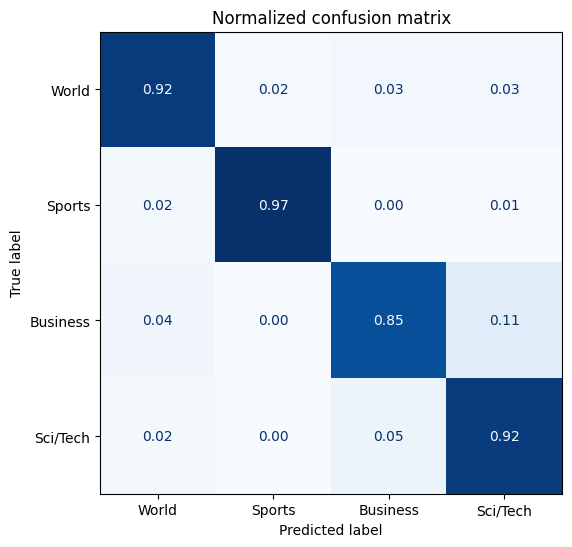

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# 予測されたラベルをIDに変換する
label_to_id = {name: i for i, name in enumerate(label_names)}
pred_labels = [label_to_id[pred["label"]] for pred in model_preds]

# 混同行列を求める
confusion_matrix = evaluate.load("confusion_matrix")
cm = confusion_matrix.compute(
    references=references, predictions=pred_labels, normalize="true"
)["confusion_matrix"]

# 混同行列をプロットする
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
plt.title("Normalized confusion matrix")
plt.show()

## テキスト生成


In [24]:
filtered_datasets = raw_datasets.filter(lambda example: example["label"] == 2)
filtered_datasets = filtered_datasets.remove_columns("label")

Filter:   0%|          | 0/120000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7600 [00:00<?, ? examples/s]

### 生成モデルの訓練

In [25]:
from transformers import AutoModelForCausalLM

model_id = "HuggingFaceTB/SmolLM-135M"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = (
    tokenizer.eos_token
)  # SmolLMはパディング用のトークンを指定していないため、明示的に設定する
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/538M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [26]:
def tokenize_function(batch):
    return tokenizer(batch["text"], truncation=True)

tokenized_datasets = filtered_datasets.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"],  # input_idsとattention_maskのみ必要
)

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/1900 [00:00<?, ? examples/s]

In [27]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 30000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 1900
    })
})

In [28]:
from transformers import DataCollatorForLanguageModeling

# mlmはマスク付き言語モデル（masked language modeling）の略
# 今回はマスク付き言語モデルを訓練するわけではなく、
# 因果言語モデル（causal language model）を訓練するためFalseに設定する
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [29]:
samples = [tokenized_datasets["train"][i] for i in range(3)]

for sample in samples:
    print(f"input_ids shape: {len(sample['input_ids'])}")

input_ids shape: 39
input_ids shape: 56
input_ids shape: 51


In [30]:
out = data_collator(samples)
for key in out:
    print(f"{key} shape: {out[key].shape}")

input_ids shape: torch.Size([3, 56])
attention_mask shape: torch.Size([3, 56])
labels shape: torch.Size([3, 56])


In [31]:
training_args = TrainingArguments(
    "business-news-generator",
    push_to_hub=True,
    per_device_train_batch_size=8,
    weight_decay=0.1,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    num_train_epochs=2,
    eval_strategy="steps",
    eval_steps=200,
    logging_steps=200,
    report_to="none"
)

In [32]:
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"].select(range(5000)),
    eval_dataset=tokenized_datasets["test"],
)

/tmp/ipython-input-32-2651450017.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [33]:
trainer.train()

TrainOutput(global_step=1250, training_loss=2.188173187255859, metrics={'train_runtime': 341.7104, 'train_samples_per_second': 29.265, 'train_steps_per_second': 3.658, 'total_flos': 618751530187776.0, 'train_loss': 2.188173187255859, 'epoch': 2.0})

In [ ]:
trainer.push_to_hub()

Uploading...:   0%|          | 0.00/538M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/egglang/business-news-generator/commit/73531a15b211b7d5020feb4227265c7e8a23e45f', commit_message='End of training', commit_description='', oid='73531a15b211b7d5020feb4227265c7e8a23e45f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/egglang/business-news-generator', endpoint='https://huggingface.co', repo_type='model', repo_id='egglang/business-news-generator'), pr_revision=None, pr_num=None)

In [34]:
from transformers import pipeline

pipe = pipeline(
    "text-generation",
    model="genaibook/business-news-generator",   # 自分が作成した名称に変更する
    device=device,
)
print(
    pipe("Q1", do_sample=True, temperature=0.1, max_new_tokens=30)[0][
        "generated_text"
    ]
)
print(
    pipe("Wall", do_sample=True, temperature=0.1, max_new_tokens=30)[0][
        "generated_text"
    ]
)
print(
    pipe("Google", do_sample=True, temperature=0.1, max_new_tokens=30)[0][
        "generated_text"
    ]
)

config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/538M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/863 [00:00<?, ?B/s]

Device set to use cuda


Q1: China #39;s Airline Unions Reject Offer China #39;s Airline Group, the world #39;
Wall Street Seen Flat After Jobless Data  NEW YORK (Reuters) - Wall Street was seen looking flat on  Friday after a report showed
Google IPO Imminent Google #39;s long-awaited stock sale is imminent, and the company is already weighing whether to sell its


## アダプターの概要

In [35]:
from peft import LoraConfig, get_peft_model

peft_config = LoraConfig(
    r=8, lora_alpha=32, lora_dropout=0.05, task_type="CAUSAL_LM"
)

model = AutoModelForCausalLM.from_pretrained("HuggingFaceTB/SmolLM-135M")
peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters()

trainable params: 460,800 || all params: 134,975,808 || trainable%: 0.3414


## 量子化の簡単な紹介

In [36]:
model = AutoModelForCausalLM.from_pretrained("gpt2", torch_dtype=torch.float16)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [37]:
import numpy as np

def scaling_factor(vector):
    # ベクトルの最大値を得る
    m = np.max(np.abs(vector))

    # 係数を求める
    return 127 / m


array = [1.2, -0.5, -4.3, 1.2, -3.1, 0.8, 2.4, 5.4, 0.3]
alpha = scaling_factor(array)
quantized_array = np.round(alpha * np.array(array)).astype(np.int8)
dequantized_array = quantized_array / alpha

print(f"Scaling factor: {alpha}")
print(f"Quantized array: {quantized_array}")
print(f"Dequantized array: {dequantized_array}")
print(f"Difference: {array - dequantized_array}")

Scaling factor: 23.518518518518515
Quantized array: [  28  -12 -101   28  -73   19   56  127    7]
Dequantized array: [ 1.19055118 -0.51023622 -4.29448819  1.19055118 -3.10393701
  0.80787402  2.38110236  5.4         0.2976378 ]
Difference: [ 0.00944882  0.01023622 -0.00551181  0.00944882  0.00393701
 -0.00787402  0.01889764  0.          0.0023622 ]


In [38]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(load_in_8bit=True)
model = AutoModelForCausalLM.from_pretrained(
    "gpt2",
    quantization_config=quantization_config
)

## すべてをまとめる


In [39]:
quantization_config = BitsAndBytesConfig(load_in_4bit=True)

model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-v0.3",
    quantization_config=quantization_config,
    device_map="auto",
)

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [41]:
from datasets import load_dataset
from trl import SFTConfig, SFTTrainer
from peft import LoraConfig, get_peft_model

dataset = load_dataset("timdettmers/openassistant-guanaco", split="train")
eval_dataset = load_dataset("timdettmers/openassistant-guanaco", split="test")

peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    task_type="CAUSAL_LM",
)

sft_config = SFTConfig(
    "fine_tune_e2e",
    push_to_hub=True,
    per_device_train_batch_size=8,
    weight_decay=0.1,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    num_train_epochs=2,
    eval_strategy="steps",
    eval_steps=200,
    logging_steps=200,
    gradient_checkpointing=True,
    # max_seq_length=512,
    max_length=512,
    # 新たなパラメーター
    dataset_text_field="text",
    packing=True,
    report_to="none",
)

trainer = SFTTrainer(
    model,
    args=sft_config,
    train_dataset=dataset.select(range(300)),
    eval_dataset=eval_dataset.select(range(100)),
    peft_config=peft_config,
)

trainer.train()

Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Adding EOS to train dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

Packing train dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Packing eval dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


TrainOutput(global_step=52, training_loss=1.129592748788687, metrics={'train_runtime': 464.1161, 'train_samples_per_second': 0.896, 'train_steps_per_second': 0.112, 'total_flos': 8830013875224576.0, 'train_loss': 1.129592748788687, 'entropy': 1.182284658918014, 'num_tokens': 206776.0, 'mean_token_accuracy': 0.7142275376961782, 'epoch': 2.0})

In [ ]:
trainer.push_to_hub()

Uploading...:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/egglang/fine_tune_e2e/commit/b059b8d17413bf5e2fd0ea5834c554d51b2ca975', commit_message='End of training', commit_description='', oid='b059b8d17413bf5e2fd0ea5834c554d51b2ca975', pr_url=None, repo_url=RepoUrl('https://huggingface.co/egglang/fine_tune_e2e', endpoint='https://huggingface.co', repo_type='model', repo_id='egglang/fine_tune_e2e'), pr_revision=None, pr_num=None)

In [42]:
from transformers import AutoTokenizer
import torch
from transformers import pipeline
from genaibook.core import get_device

device = get_device()

# 先ほどと同様にベースモデルを読み込む
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.3")
model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-v0.3",
    torch_dtype=torch.float16,
    device_map="auto",
)

# `load_adapter`でアダプターを読み込む
model.load_adapter("genaibook/fine_tune_e2e")  # 自分が作成した名称に変更する

# あるいは、アダプター名を使って`from_pretrained`を呼び出すだけでも
# ベースモデルとアダプターモデルの両方を自動的に読み込んでくれる
# model = AutoModelForCausalLM.from_pretrained("genaibook/fine_tune_e2e"...

pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
pipe("### Human: Hello!### Assistant:", max_new_tokens=100)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/13.6M [00:00<?, ?B/s]

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '### Human: Hello!### Assistant: Hi, how can I help you?'}]

In [43]:
pipe = pipeline(
    "text-generation", "HuggingFaceTB/SmolLM-135M-Instruct", device=device
)
messages = [
    {
        "role": "system",
        "content": """You are a friendly chatbot who always responds
        in the style of a pirate""",
    },
    {
        "role": "user",
        "content": "How many helicopters can a human eat in one sitting?",
    },
]
print(pipe(messages, max_new_tokens=128)[0]["generated_text"][-1])

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

Device set to use cuda


{'role': 'assistant', 'content': "The age-old question of helicopter feeding!\n\nAccording to various sources, including the United States Navy, the International Committee of the Red Cross, and the World Health Organization, a human can only consume a limited number of helicopters per sitting. Here's a breakdown of the current guidelines and the limitations:\n\n**Microlight Helicopters:**\n\n* The United States Navy has established a maximum number of Microlight Helicopters as of 2022.\n* A Microlight Helicopter can live up to 10 minutes in the air.\n* To avoid overcrowding, the Navy has prohibited Mic"}


In [44]:
tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM-135M-Instruct")

chat = [
    {"role": "user", "content": "Hello, how are you?"},
    {
        "role": "assistant",
        "content": "I'm doing great. How can I help you today?",
    },
    {
        "role": "user",
        "content": "I'd like to show off how chat templating works!",
    },
]

tokenizer.apply_chat_template(chat, tokenize=False)

"<|im_start|>user\nHello, how are you?<|im_end|>\n<|im_start|>assistant\nI'm doing great. How can I help you today?<|im_end|>\n<|im_start|>user\nI'd like to show off how chat templating works!<|im_end|>\n"

In [45]:
print(tokenizer.apply_chat_template(chat, tokenize=False))

<|im_start|>user
Hello, how are you?<|im_end|>
<|im_start|>assistant
I'm doing great. How can I help you today?<|im_end|>
<|im_start|>user
I'd like to show off how chat templating works!<|im_end|>



## 解答

### 演習

**1. ベースモデルとファインチューニング済みモデルの違いは何か。また、会話型モデルとはどのようなモデルか。**

* **ベースモデル:** ベースモデルとは、大規模なデータセットで一般的な言語モデルタスクをこなせるように事前訓練されたモデルである。このモデルをベースにさらに特定のタスクに適応させることができる。
* **ファインチューニング済みモデル:**  ファインチューニング済みモデルとは、ベースモデルをさらに小規模かつ特定用途向けのデータセットで追加学習させたものである。パラメータを調整することで、特定の分野やタスクでの性能を高めることができる。要約、テキスト分類、固有表現抽出などに特化したモデルが例として挙げられる。
* **会話型モデル:** 会話型モデルとは、特に会話の文脈で応答を生成できるようにファインチューニングされたモデルである。対話やチャット形式のデータセットで追加学習されており、会話のやりとりに適した一貫性のある応答を生成することができる。

**2. どのような場合にエンコーダーベースのモデルをファインチューニングするべきか。**

ファインチューニングは、分類、固有表現抽出、質問応答など、文章の理解を要するタスクで有効である。BERTのようなエンコーダモデルは、文脈に応じた埋め込み表現を生成でき、計算効率も高いため、しばしばベースモデルとして利用される。

ただし、以下のような場合は、ファインチューニングを行わずにベースエンコーダーモデルをそのまま使うこともある。

* **ゼロショット・少数ショットの能力が強力な場合** こうした能力があれば、追加の訓練なしでも特定タスクで十分な性能が得られる場合がある。
* **リソースに制約がある場合** ファインチューニングには追加の計算リソースや時間が必要となる。
* **一般的なタスクの場合** タスク自体が一般的で、事前学習とほぼ同じ内容である場合は、ベースモデルのみでも十分な場合がある。

**3. ファインチューニング、インストラクションチューニング、QLoRAの違いを説明せよ。**

* **ファインチューニング:** 事前訓練済みモデルを選び、タスクやドメインに特化させるために追加で訓練させる手法である。モデルのパラメーターを調整し、対象タスクでの性能向上を図る。
* **インストラクションチューニング:** ファインチューニングの一種で、インストラクション形式（命令形式）のデータセットを使う。さまざまなタスクを命令として与え、モデルが新しいタスクにも柔軟に対応できるようにする。
* **QLoRA:** LoRAは、モデル本体は凍結したまま、アダプター（追加の小規模パラメーター群）のみを更新するファインチューニング手法である。QLoRAはLoRAの一種で、ベースモデルを量子化（低ビット化）してGPUメモリ消費を削減する手法である。

**4. アダプターを使うと、モデルのサイズは大きくなるか。**

アダプターは、モデルサイズにごく小さなオーバーヘッドを加えるのみである。アダプターの重みをベースモデルにマージして元のサイズに戻すことができる。これには`merge_and_unload`を利用できる。


**5. 70Bモデルをハーフ精度、8ビット量子化、4ビット量子化でロードする場合、それぞれどの程度のGPUメモリが必要か。**

おおまかな数値は以下の通りである。厳密ではないが目安にはなるだろう。

* **フル精度**: 70Bパラメータ × 4バイト（32ビット）＝ 280GB
* **半精度**: 70Bパラメータ×2バイト（16ビット）＝140GB
* **8ビット量子化**: 70Bパラメータ×1バイト（8ビット）＝70GB
* **4ビット量子化**: 70Bパラメータ×0.5バイト（4ビット）＝35GB

なお、GPUにロードする際に追加のオーバーヘッドも発生する場合がある。


**6. なぜQLoRAは訓練が遅いのか。**

QLoRAはメモリ使用量を削減できる一方で、訓練中に追加の量子化・逆量子化処理が入るため計算負荷が増す。そのため、これらの余分な処理が原因で訓練の速度が低下する。

**7. ファインチューニング時にモデルの重みを凍結するのはどのような場合か。**

Transformerモデルのファインチューニングにおいて、通常は重みを凍結しない。しかし、PEFTのような一部の手法や特徴抽出器としてモデルを使いたい場合には重みを凍結することが有効である。たとえば、事前訓練済みモデルを特徴抽出器として利用し、その出力をSVMやランダムフォレストなどの従来型モデルに入力するなどの用途が考えられる。また、極めて限られたデータしかない場合には、モデル全体のほとんどを凍結し、最後の層のみをファインチューニングする方法も有効である。


### 課題

**8. 画像分類** 本章では自然言語処理タスクにおけるTransformerモデルのファインチューニングに焦点を当ててきたが、Transformerは音声や画像処理といった他の形式にも応用できる。この課題の目標は、画像分類向けにTransformerモデルをファインチューニングすることだ。次のような方法がある。

* [google/vit-base-patch16-224-in21k](https://huggingface.co/google/vit-base-patch16-224-in21k)のような事前訓練済みのViTモデルを使う
* [food101](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/)のような画像とラベルのデータセットを使う



`food101`データセットには101種類の食品カテゴリが含まれており、合計101,000枚の画像が存在する。ここではファインチューニングのプロセスが正しく動作するかどうかを検証するため、データのごく一部（5,000枚の画像）のみを使用するが、もっと多くのデータを使ったり、追加の実験を行ったりしても構わない。

In [ ]:
from datasets import load_dataset

food = load_dataset("food101", split="train[:5000]")

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00008.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

train-00001-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

train-00002-of-00008.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

train-00003-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

train-00004-of-00008.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

train-00005-of-00008.parquet:   0%|          | 0.00/470M [00:00<?, ?B/s]

train-00006-of-00008.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

train-00007-of-00008.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

validation-00000-of-00003.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

validation-00001-of-00003.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

validation-00002-of-00003.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

In [ ]:
food

Dataset({
    features: ['image', 'label'],
    num_rows: 5000
})

このデータセットを訓練用とテスト用に分割しよう。

In [ ]:
food = food.train_test_split(test_size=0.2, seed=42)

In [ ]:
sample = food["train"][1]
sample

{'image': <PIL.Image.Image image mode=RGB size=512x512>, 'label': 6}

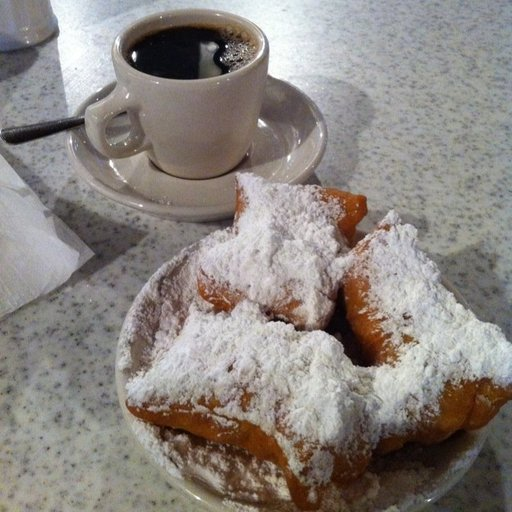

In [ ]:
sample["image"]

美味しそうだが、これは何だろうか。データセット内でラベル6は何に対応しているか確認しよう。

In [ ]:
labels = food["train"].features["label"].names
labels[6]

'beignets'

なお、今回使用する5,000サンプルのサブセットには、101カテゴリすべてが含まれているわけではなく、そのうちの一部しか含まれていない。実際に、訓練用データセットとテスト用データセットにどのクラスが含まれているかを確認してみる。

In [ ]:
import numpy as np
np.unique(np.array(food["train"]["label"]), return_counts=True)

(array([ 6, 10, 20, 53, 77, 79, 81]),
 array([611, 607, 596, 602, 389, 584, 611]))

In [ ]:
np.unique(np.array(food["test"]["label"]), return_counts=True)

(array([ 6, 10, 20, 53, 77, 79, 81]),
 array([139, 143, 154, 148, 111, 166, 139]))


元のデータセットにある101クラスのうち、今回使うのは7クラスのみである。これら7クラスの中から写真を識別できるように分類器を訓練する。そのためには、クラスIDとして0から6までの連番を使う必要がある。これは、分類器が出力セルの順序（確率が最も高いセル）でクラスを選択するため、連続した番号で0から始まる必要があるためである。

別の方法としては、101クラスすべてを出力の候補として設定し、サブセットに含まれる7クラスだけをサンプルとして与える方法も考えられる。この場合でもモデルの訓練は可能だ（実際に試してみてもよい）が、やや難易度が上がる。

それでは、新しいラベルからクラス名への辞書、およびその逆の辞書を作成しよう。また、元のラベルID（データセット内のすべてのクラス）から、今回ファインチューニングで使う0～6の新しいラベルIDへの対応表も作成する。


In [ ]:
label2id, id2label, original2id = dict(), dict(), dict()
finetuning_label_ids = np.unique(np.array(food["test"]["label"]))
for i, old_label_id in enumerate(finetuning_label_ids):
    label = labels[old_label_id]
    label2id[label] = str(i)
    id2label[str(i)] = label
    original2id[old_label_id] = i

In [ ]:
id2label

{'0': 'beignets',
 '1': 'bruschetta',
 '2': 'chicken_wings',
 '3': 'hamburger',
 '4': 'pork_chop',
 '5': 'prime_rib',
 '6': 'ramen'}

次に、データセットを前処理する。画像の前処理には`AutoTokenizer`ではなく、`AutoImageProcessor`を使用する。トークナイザーと同様に、プロセッサーもモデルに紐づいている。

In [ ]:
from transformers import AutoImageProcessor

model_id = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(model_id)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


[プリプロセッサーの設定](https://huggingface.co/google/vit-base-patch16-224-in21k/blob/main/preprocessor_config.json)を見ると、入力画像を224x224にリサイズし、値を-1から1の範囲に正規化することがわかる。また、PIL画像からPyTorchのテンソルへの変換も自動的に行ってくれる。


In [ ]:
preprocessed = image_processor(images=[sample["image"]], return_tensors="pt")["pixel_values"][0]
preprocessed.shape, preprocessed.min(), preprocessed.max()

(torch.Size([3, 224, 224]), tensor(-1.), tensor(1.))

組み込みのプロセッサーを利用することで、入力データが事前訓練時に適用されたものと同じ手順で変換される。もちろん、タスクに応じて他の変換を検討してもよい。たとえば、アスペクト比を維持したい場合はリサイズ前に正方形にクロップする、またはデータ拡張を行うなどが考えられる。

変換処理のもう一つのステップとして、元のクラスIDを新しいクラスIDにマッピングする必要がある。


In [ ]:
def preprocess(examples):
    examples.update(image_processor(examples["image"], return_tensors="pt"))
    examples["label"] = [original2id[x] for x in examples["label"]]
    del examples["image"]
    return examples

In [ ]:
food = food.with_transform(preprocess)

また、データをバッチ化するために`DefaultDataCollator`を使用する。このコレーターは前処理は一切行わず、単にデータをまとめてバッチ化するだけだ。今回の例のように、すべての入力テンソルがすでに同じ形状を持っている場合に利用できる。


In [ ]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

モデルの評価にaccuracyを確認してみよう。

In [ ]:
from transformers import Trainer, TrainingArguments
import evaluate

In [ ]:
accuracy = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

最後にベースモデルを読み込む。必須ではないが、`id2label`や`label2id`をモデルに追加することもできる。これによりクラス名とラベルの相互変換が容易になり、`config.json`にもこの情報が追加される。

In [ ]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained(
    model_id,
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id,
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


訓練を開始しよう。手順はこれまでとほぼ同じだ。

In [ ]:
batch_size = 32 # GPUに合わせて変更する

training_args = TrainingArguments(
    "my-food-model",
    num_train_epochs=3,
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=5e-5,
    gradient_accumulation_steps=1,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    push_to_hub=True,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=food["train"],
    eval_dataset=food["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

/tmp/ipython-input-33-864076306.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


TrainOutput(global_step=375, training_loss=0.504115966796875, metrics={'train_runtime': 157.2371, 'train_samples_per_second': 76.318, 'train_steps_per_second': 2.385, 'total_flos': 9.29945547546624e+17, 'train_loss': 0.504115966796875, 'epoch': 3.0})

3エポックでの精度は約94%となった

In [ ]:
trainer.push_to_hub()

Uploading...:   0%|          | 0.00/343M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/egglang/my-food-model/commit/dd6c5836ea5bcc1d404ae3148bc03a60471264e2', commit_message='End of training', commit_description='', oid='dd6c5836ea5bcc1d404ae3148bc03a60471264e2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/egglang/my-food-model', endpoint='https://huggingface.co', repo_type='model', repo_id='egglang/my-food-model'), pr_revision=None, pr_num=None)

次に、`image-classification`パイプラインを利用して、冒頭の画像を分類してみる。

In [ ]:
from transformers import pipeline

classifier = pipeline("image-classification", model="pcuenq/my-food-model")
classifier(sample["image"])

config.json:   0%|          | 0.00/963 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


[{'label': 'beignets', 'score': 0.9071165919303894},
 {'label': 'hamburger', 'score': 0.017487000674009323},
 {'label': 'ramen', 'score': 0.017378918826580048},
 {'label': 'prime_rib', 'score': 0.01568443886935711},
 {'label': 'chicken_wings', 'score': 0.01490048598498106}]

うまくいった。ぜひ、以下も試してみてほしい。

* モデルが確信度高く予測したにもかかわらず、ラベルと一致しなかった検証セットのサンプルを探してみよう。どちらが正しいだろうか。
* Swin Transformer、MobileViT、ConvNeXTなどの他のモデルも試してみよう。
* 3クラス、各クラス10枚だけの自作の小さなデータセットで訓練し、そのモデルの性能を確認してみよう。